In [1]:
import sys
sys.path.insert(0,'../street2sat_utils/')
import client
import exif_utils
import cv2
import json
import exifread
import PIL.Image
import base64
import io
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Loading model weights and images

In [2]:
model = client.get_model('../street2sat_utils/model_weights/best.pt')
img1_path = 'example_images/GP__1312.JPG'
img2_path = 'example_images/GP__1313.JPG'
img3_path = 'example_images/GP__1314.JPG'

Fusing layers... 
Model Summary: 308 layers, 21082089 parameters, 0 gradients
Adding AutoShape... 
YOLOv5 🚀 ff22205 torch 1.8.1 CPU



### Read image using Open CV and convert colors

In [3]:
img1 = cv2.cvtColor(cv2.imread(img1_path), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(img2_path), cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(cv2.imread(img3_path), cv2.COLOR_BGR2RGB)
print(img1.shape, img2.shape, img3.shape)

(2028, 2704, 3) (2028, 2704, 3) (2028, 2704, 3)


### Run prediction on all images 
Load as json 

In [4]:
%%time
results1 = client.run_prediction(img1, model)
results1 = json.loads(results1)

results2 = client.run_prediction(img2, model)
results2 = json.loads(results2)

results3 = client.run_prediction(img3, model)
results3 = json.loads(results3)

CPU times: user 2.99 s, sys: 350 ms, total: 3.34 s
Wall time: 4.34 s


### Open image and parse exif data

In [5]:
%%time
img1_file = open(img1_path, 'rb')
tags1 = exifread.process_file(img1_file)

img2_file = open(img2_path, 'rb')
tags2 = exifread.process_file(img2_file)

img3_file = open(img3_path, 'rb')
tags3 = exifread.process_file(img3_file)

CPU times: user 24.6 ms, sys: 5.2 ms, total: 29.8 ms
Wall time: 34.2 ms


### Extract needed exif data using exif_utils and save to a tag dict associated with each uploaded image

In [6]:
def get_needed_tags(tags):
    lat_long = exif_utils.get_exif_location(tags)
    taken_time = exif_utils.get_exif_datetime(tags)
    focal_length = exif_utils.get_exif_focal_length(tags)
    pixel_height, pixel_width = exif_utils.get_exif_image_height_width(tags)
    tag_dict = {}
    tag_dict['lat_long'] = lat_long
    tag_dict['taken_time'] = taken_time
    tag_dict['focal_length'] = focal_length
    tag_dict['pixel_width'] = pixel_width
    tag_dict['pixel_height'] = pixel_height
    return tag_dict

tags1 = get_needed_tags(tags1)
tags2 = get_needed_tags(tags2)
tags3 = get_needed_tags(tags3)

print(tags1)
print(tags2)
print(tags3)

{'lat_long': (0.6752619999999999, 34.7491525), 'taken_time': datetime.datetime(2020, 12, 16, 8, 42, 54), 'focal_length': 3, 'pixel_width': 2704, 'pixel_height': 2028}
{'lat_long': (0.6805182999999999, 34.7490718), 'taken_time': datetime.datetime(2020, 12, 16, 8, 45, 35), 'focal_length': 3, 'pixel_width': 2704, 'pixel_height': 2028}
{'lat_long': (0.6807162, 34.7490831), 'taken_time': datetime.datetime(2020, 12, 16, 8, 45, 41), 'focal_length': 3, 'pixel_width': 2704, 'pixel_height': 2028}


### Run the distance estimation function using the values extracted from the exif_utils and model prediction bounding boxes

In [7]:
def get_distance_estimation(results, tag_dict):
    lat_long = tag_dict['lat_long']
    taken_time = tag_dict['taken_time']
    focal_length = tag_dict['focal_length'] 
    pixel_width = tag_dict['pixel_width']
    pixel_height = tag_dict['pixel_height'] 
    info = client.get_distance_meters(results, focal_length, pixel_width, pixel_height, lat_long, path_prefix = '../street2sat_utils/crop_info/')
    
    return info

res1 = get_distance_estimation(results1, tags1)
res2 = get_distance_estimation(results2, tags2)
res3 = get_distance_estimation(results3, tags3)

print(res1, res2, res3)

{'sugarcane': '20.397 meters'} {'sugarcane': '14.173 meters'} {'sugarcane': '15.826 meters'}


### Get bearing estimations

bearings will be {img_name:bearing}

new_points will be {img_name:{crop_type:(lat,long)}}

In [8]:
# time:file
file_time = {}
# file:(lat,long)
file_coord = {}
# file:distance
file_distance = {}
for file_name, tag_dict in [('img1', tags1), ('img2', tags2), ('img3', tags3)]:
    lat_long = tag_dict['lat_long']
    taken_time = tag_dict['taken_time']
    focal_length = tag_dict['focal_length'] 
    pixel_width = tag_dict['pixel_width']
    pixel_height = tag_dict['pixel_height'] 
    
    file_time[taken_time] = file_name
    file_coord[file_name] = lat_long

file_distance['img1'] = res1
file_distance['img2'] = res2
file_distance['img3'] = res3

bearings, new_points = client.get_new_points(file_time, file_coord, file_distance)


# just to follow convention like with the other dictionaries images image_name:time
file_time = dict((y,x) for x,y in file_time.items())


print(bearings)
print(new_points)

{'img1': 269.12046874982326, 'img2': 269.12046779505033, 'img3': 269.2710504885695}
{'img1': {'sugarcane': (0.675259187388663, 34.74896927843237)}, 'img2': {'sugarcane': (0.6805163456356776, 34.74894448705709)}, 'img3': {'sugarcane': (0.6807143913019371, 34.7489409332708)}}


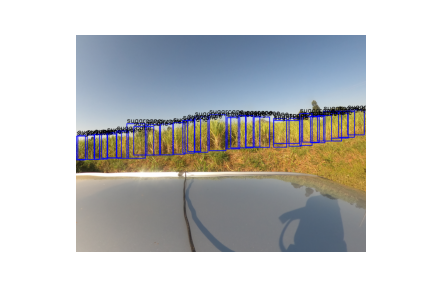

In [9]:

# Take in base64 string and return a numpy image array
def stringToRGB(base64_string):
    imgdata = base64.b64decode(base64_string)
    image = PIL.Image.open(io.BytesIO(imgdata))
    return image

s = client.plot_labels(img1, results1, path_prefix = '../street2sat_utils/crop_info/')
stringToRGB(s)
